In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

In [2]:
start_date = '2023-01-01'
end_date = '2024-01-01'
# tickers = ['NXE', 'CCL', 'PR', 'STNE', 'NAT', 'AMD', 'NVDA', 'UEC', 'XP', 'TSLA']
tickers = ['SMCI', 'AMD', 'DASH',  'CDNS', 'ADBE', 'MSFT', 'MU', 'CPRT', 'BKNG', 'AMZN']

SMCI


[*********************100%%**********************]  1 of 1 completed


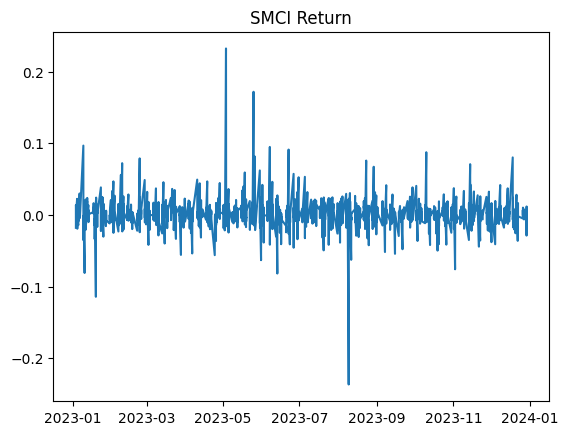

[*********************100%%**********************]  1 of 1 completed

AMD


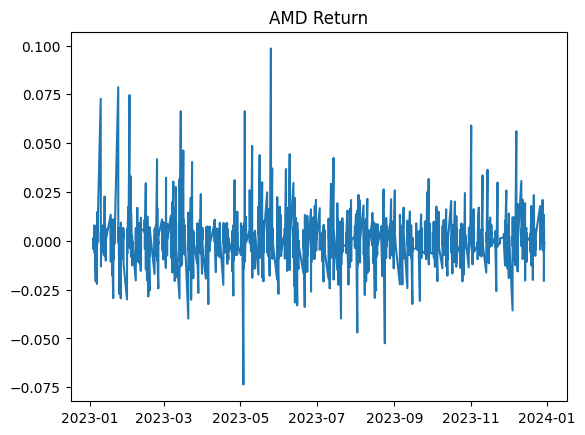

[*********************100%%**********************]  1 of 1 completed

DASH


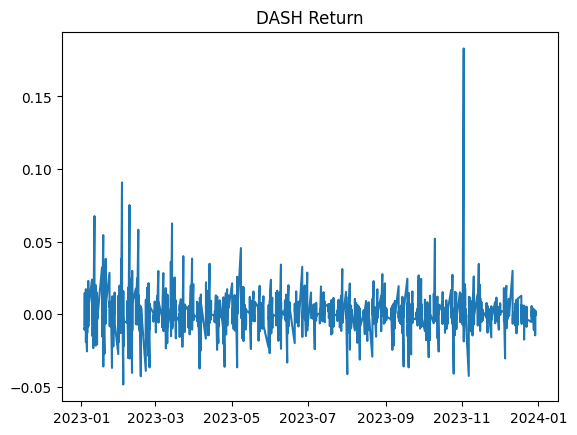

[*********************100%%**********************]  1 of 1 completed

CDNS


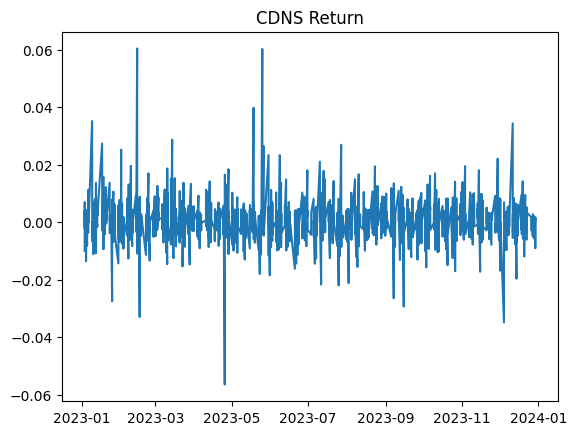

[*********************100%%**********************]  1 of 1 completed

ADBE


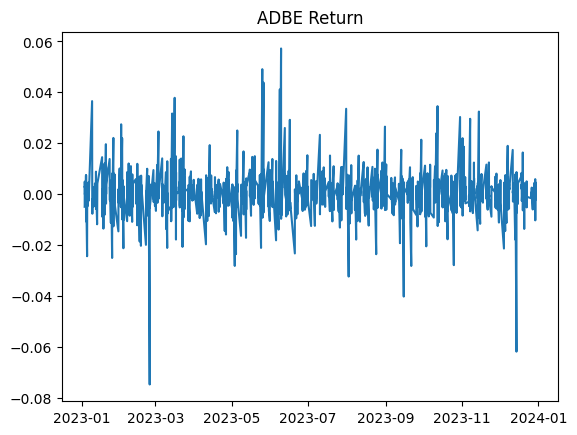

[*********************100%%**********************]  1 of 1 completed

MSFT


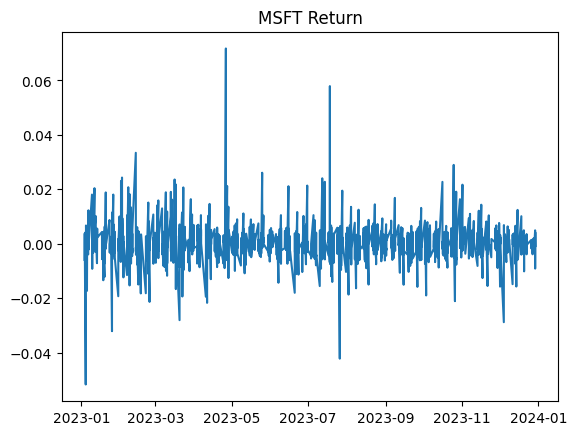

[*********************100%%**********************]  1 of 1 completed

MU


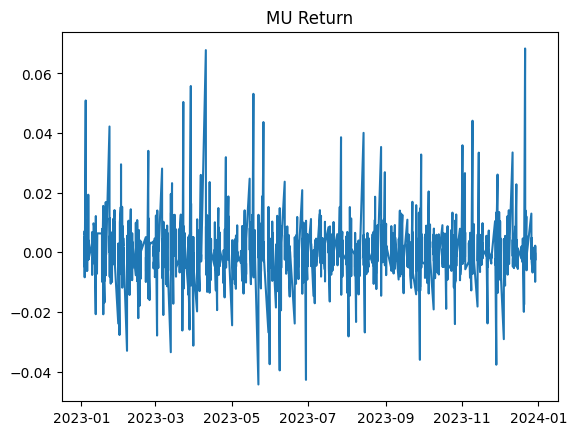

[*********************100%%**********************]  1 of 1 completed

CPRT


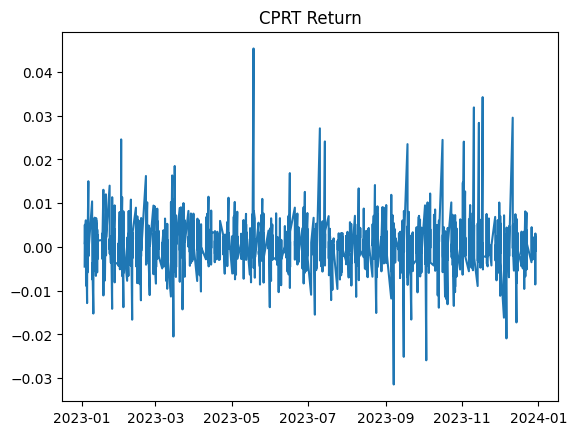

[*********************100%%**********************]  1 of 1 completed

BKNG


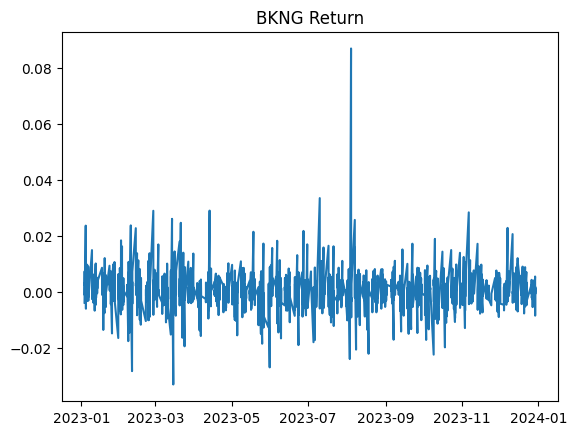

[*********************100%%**********************]  1 of 1 completed

AMZN


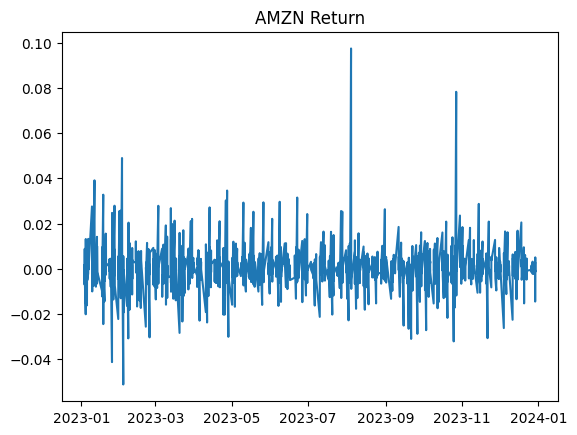

In [3]:
for ticker in tickers:
    print(ticker)
    df = yf.download(ticker, start=start_date, end=end_date, interval='1h')
    prices = df['Close']
    returns = prices.pct_change().dropna()
    plt.plot(returns)
    plt.title(f"{ticker} Return")
    plt.show()

[*********************100%%**********************]  1 of 1 completed

SMCI


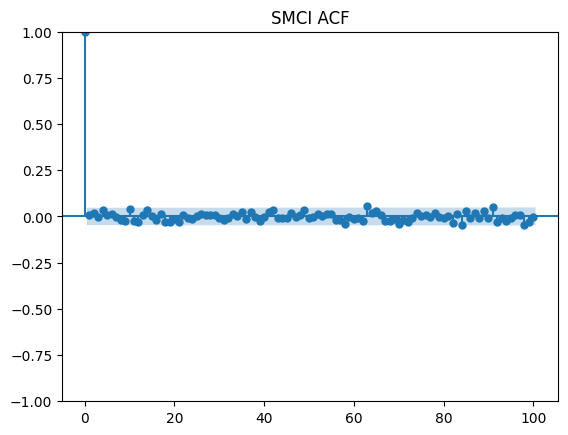

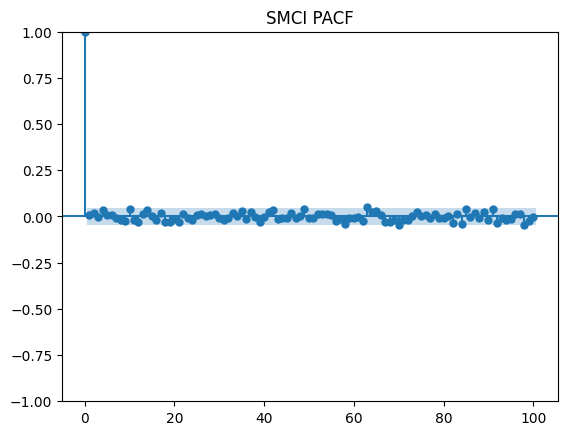

[*********************100%%**********************]  1 of 1 completed

DDOG


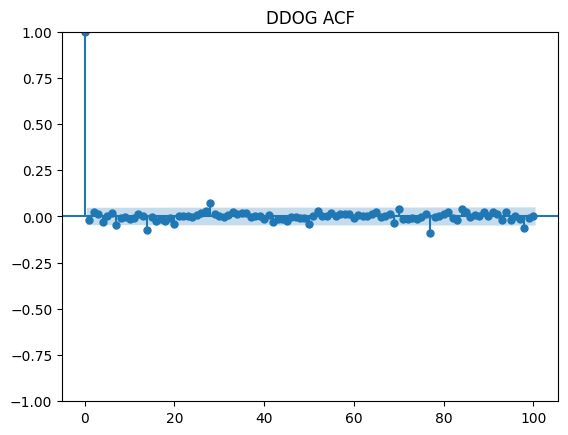

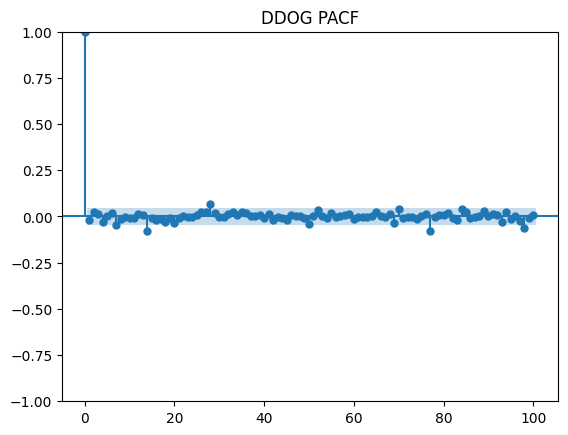

[*********************100%%**********************]  1 of 1 completed

SNPS


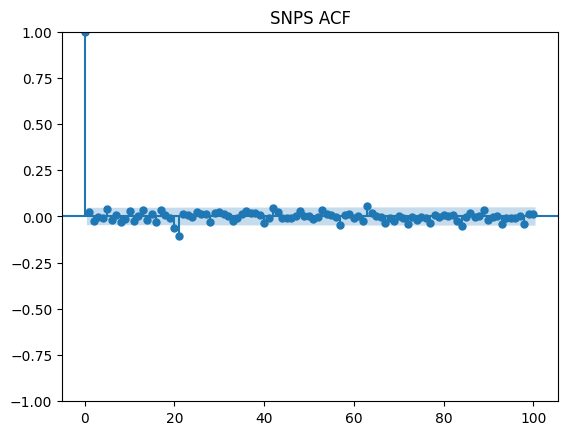

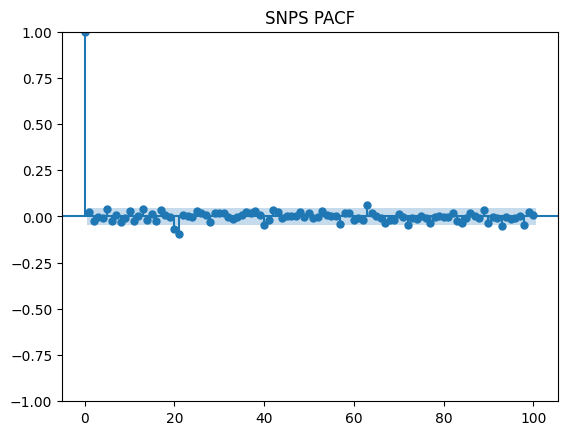

[*********************100%%**********************]  1 of 1 completed

BKNG


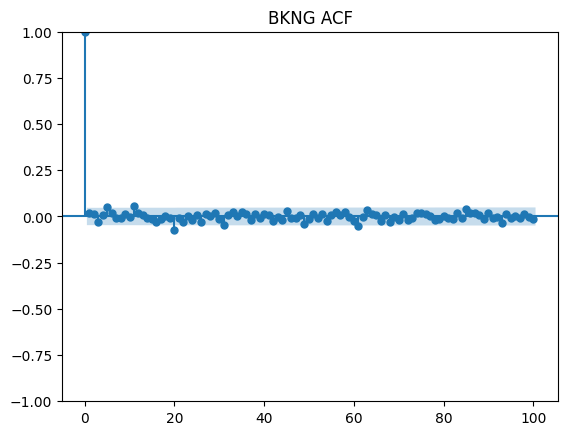

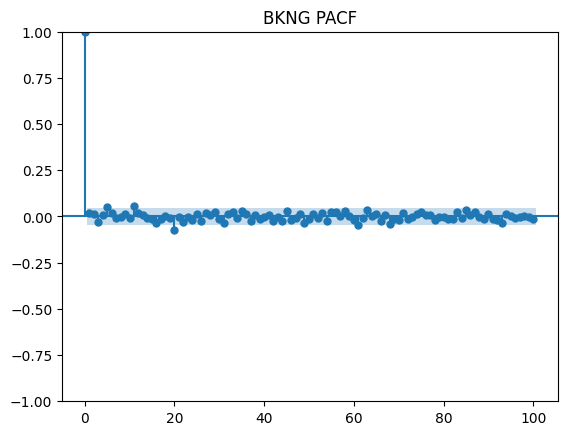

[*********************100%%**********************]  1 of 1 completed

MDB


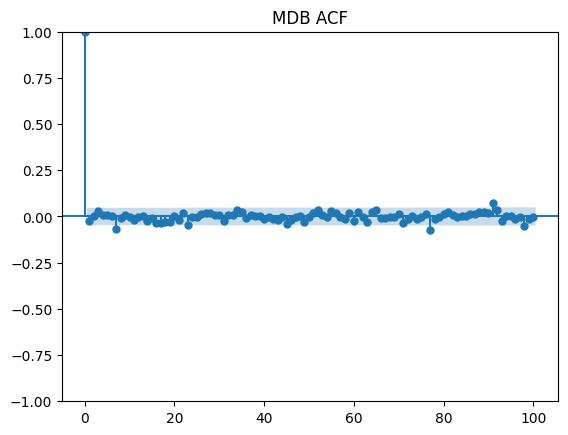

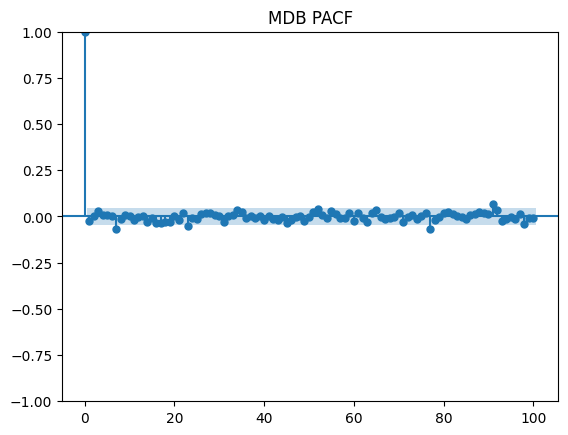

[*********************100%%**********************]  1 of 1 completed

NVDA


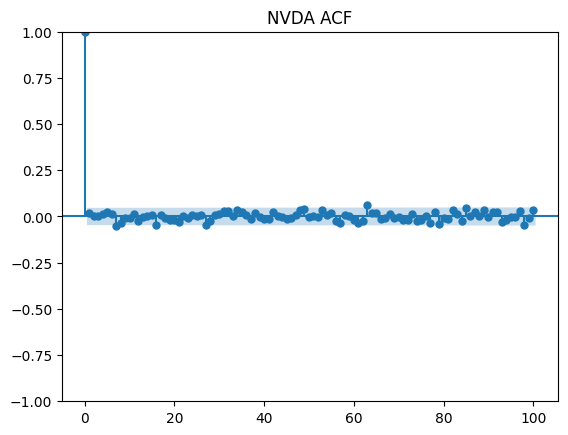

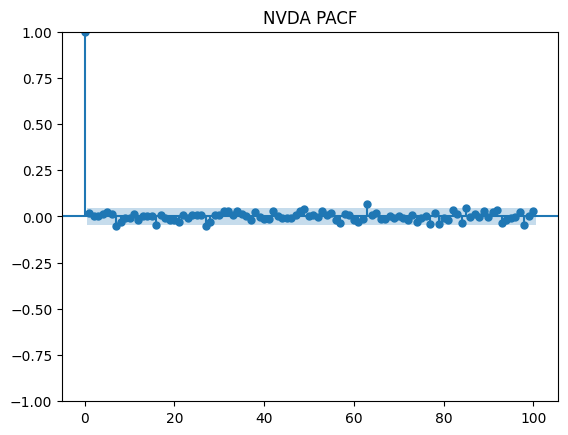

[*********************100%%**********************]  1 of 1 completed

MELI


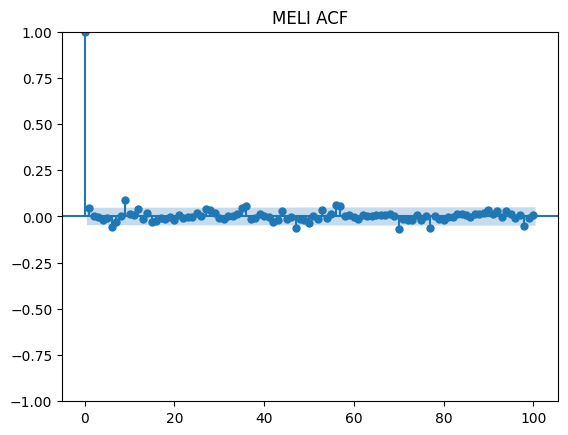

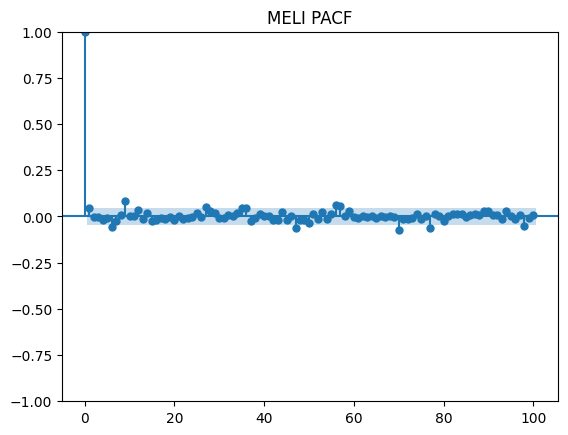

[*********************100%%**********************]  1 of 1 completed

WDAY


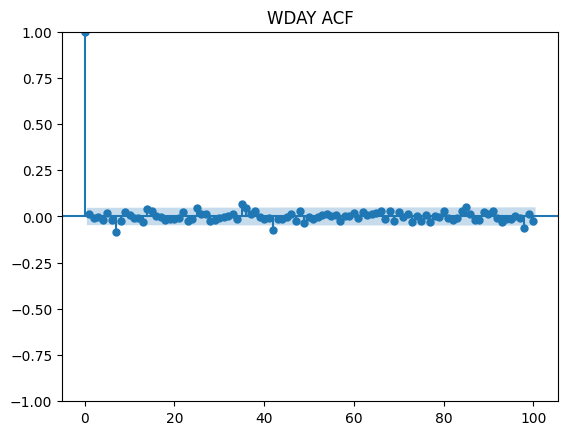

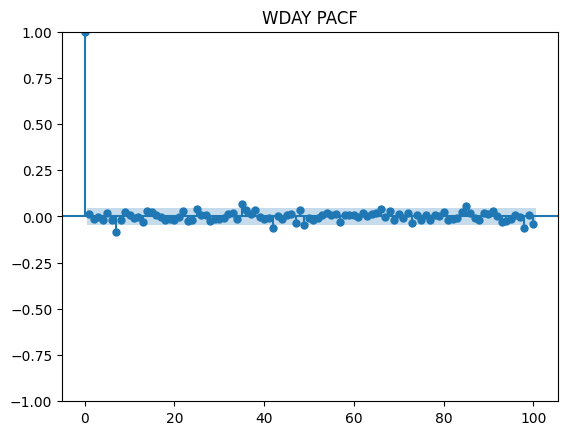

[*********************100%%**********************]  1 of 1 completed

RR.L


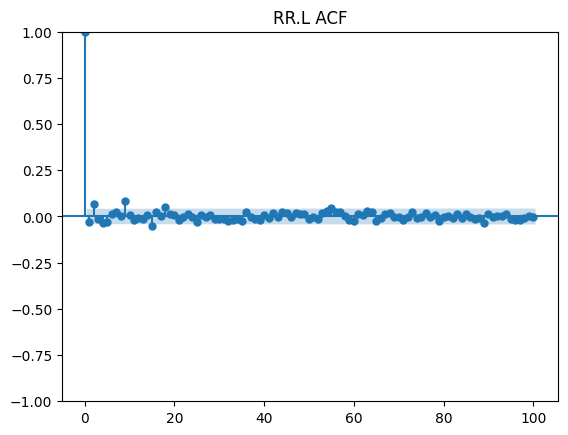

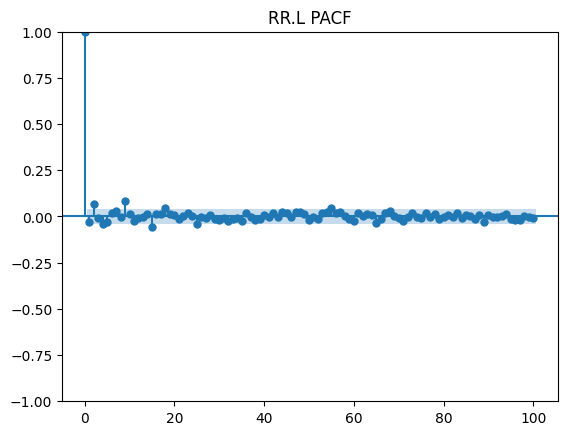

[*********************100%%**********************]  1 of 1 completed

PDD


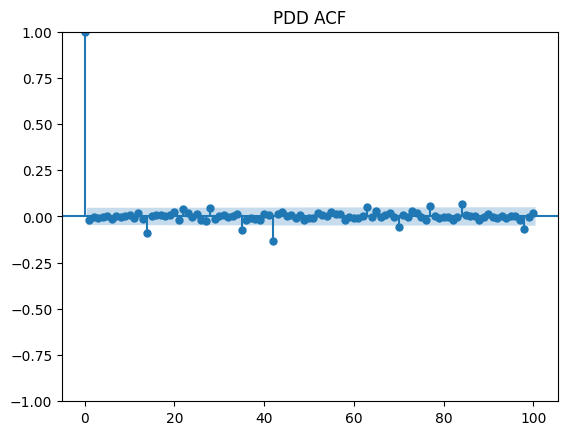

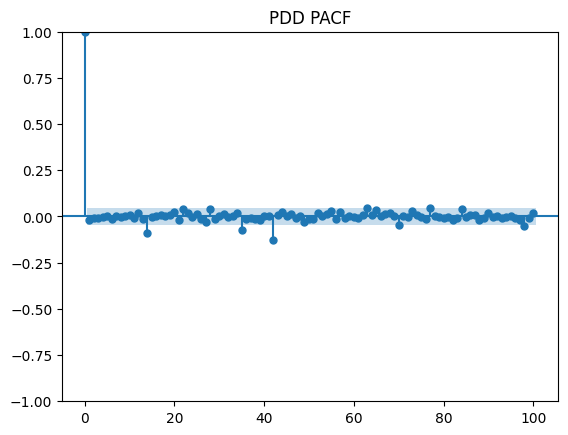

In [4]:
start_date = '2023-01-01'
end_date = '2024-01-01'
# tickers = ['NXE', 'CCL', 'PR', 'STNE', 'NAT', 'AMD', 'NVDA', 'UEC', 'XP', 'TSLA']
tickers = ['SMCI', 'DDOG', 'SNPS',  'BKNG', 'MDB', 'NVDA', 'MELI', 'WDAY', 'RR.L', 'PDD']

for ticker in tickers:
    print(ticker)
    df = yf.download(ticker, start=start_date, end=end_date, interval='1h')
    # df.dropna(axis=1, inplace=True)
    prices = df['Close']
    returns = prices.pct_change().dropna()
    plot_acf(returns, lags=100)
    plt.title(f"{ticker} ACF")
    plot_pacf(returns, lags=100)
    plt.title(f"{ticker} PACF")
    plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    df.dropna(axis=1, inplace=True)
    prices = df['Close']
    returns = prices.pct_change().dropna()
    adf_test = adfuller(returns)
    print(f'ADF Statistic for {ticker}: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ADF Statistic for SMCI: -14.791319
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for DDOG: -6.044645
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for SNPS: -10.051324
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for BKNG: -10.394294
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for MDB: -11.008243
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ADF Statistic for NVDA: -10.416602
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for MELI: -16.045675
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for WDAY: -17.162498
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for RR.L: -16.066515
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic for PDD: -15.264200
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [6]:
ff_factors = pd.read_csv('data/famafrench_daily_factor.csv')

In [7]:
ff_factors.drop(['Date_str'], axis=1, inplace=True)
ff_factors = ff_factors.set_index('Date')
ff_factors.index = pd.to_datetime(ff_factors.index)

In [8]:
from datetime import datetime
ff_factors = ff_factors.loc[datetime(2023,1,1):]

<Figure size 640x480 with 0 Axes>

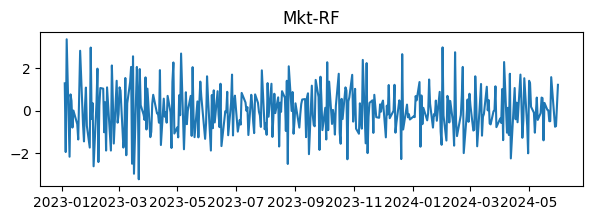

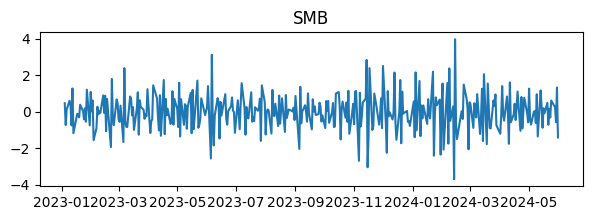

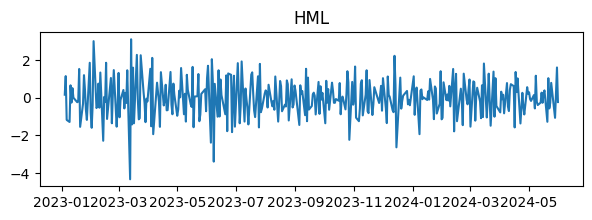

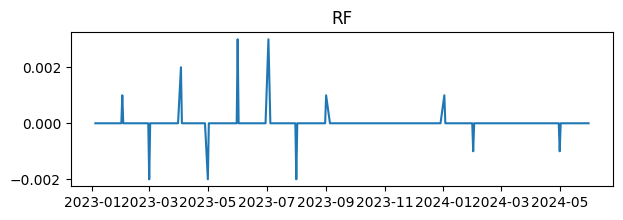

In [9]:
plt.figure()
for factor in list(ff_factors.columns):
    plt.figure(figsize=(7,2))
    plt.plot(ff_factors[factor].diff())
    plt.title(f"{factor}")
    plt.show()

<Figure size 700x200 with 0 Axes>

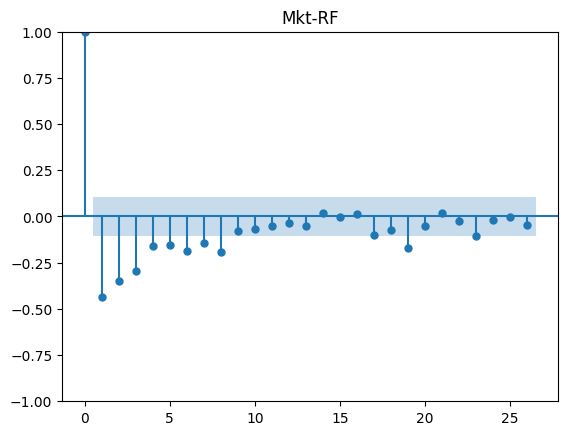

<Figure size 700x200 with 0 Axes>

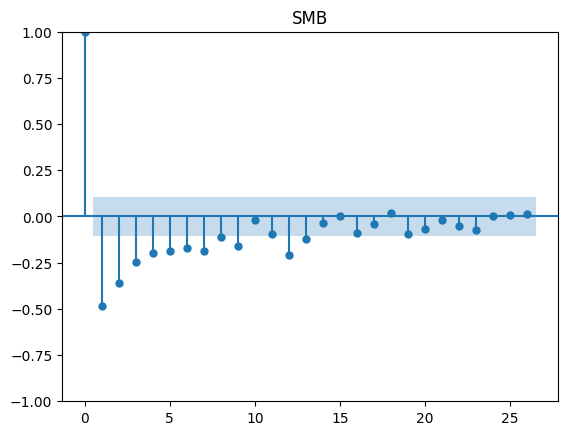

<Figure size 700x200 with 0 Axes>

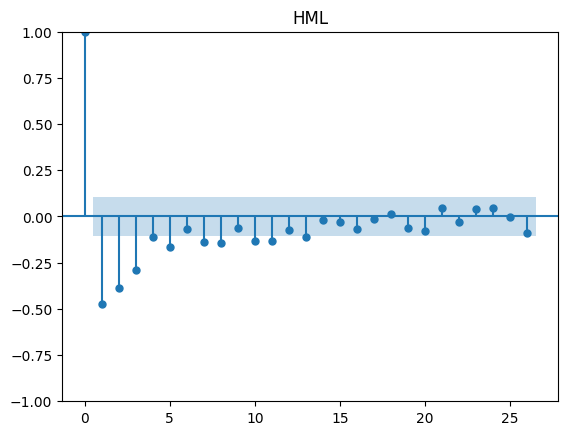

<Figure size 700x200 with 0 Axes>

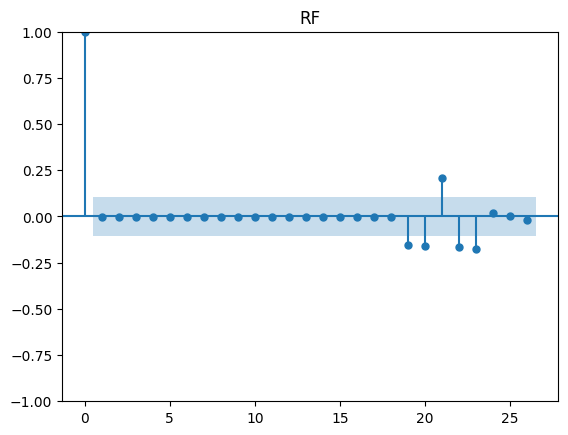

In [10]:
# fig, ax = plt.subplots(nrows=3, ncols=1)
for i, factor in enumerate(list(ff_factors.columns)):
    plt.figure(figsize=(7,2))
    plot_pacf(ff_factors[factor].diff().dropna())
    plt.title(f"{factor}")
    plt.show()

In [11]:
smci_returns = yf.download('SMCI', start=start_date, end=end_date, interval='1h')['Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


In [12]:
# Fit the ARMA(1, 1) model
model = ARIMA(smci_returns, order=(1, 0, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1741
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4517.949
Date:                Fri, 02 Aug 2024   AIC                          -9027.899
Time:                        18:39:05   BIC                          -9006.050
Sample:                             0   HQIC                         -9019.820
                               - 1741                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.971      0.049    5.03e-06       0.002
ar.L1          0.0477      5.189      0.009      0.993     -10.123      10.219
ma.L1         -0.0421      5.190     -0.008      0.9

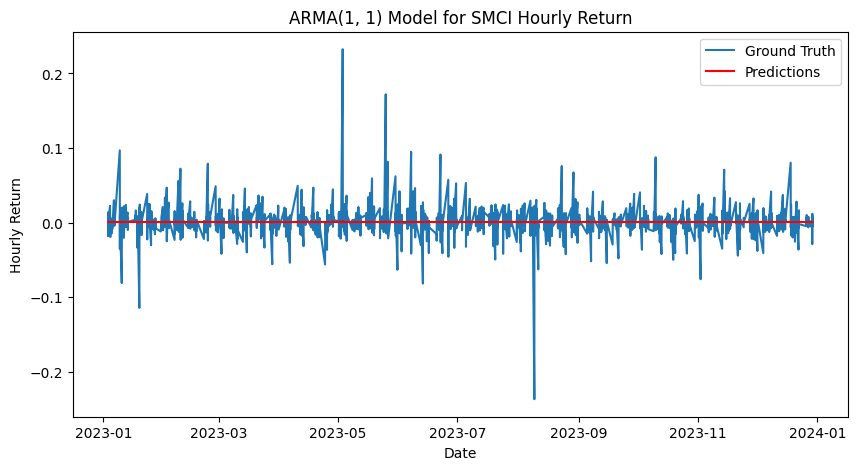

In [13]:
predictions = model_fit.predict()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(smci_returns, label='Ground Truth')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('ARMA(1, 1) Model for SMCI Hourly Return')
plt.xlabel('Date')
plt.ylabel('Hourly Return')
plt.show()